# 4 урок: Оптимизация целевого критерия

In [1]:
from IPython.display import Image, Math

import pandas as pd
import numpy as np

# Импортируем библиотеки для визуализаци данных
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig()
logger = logging.getLogger("optimisation")
logger.setLevel(logging.INFO)

# Что будем делать?

- имплементируем 3 разных подхода оптимизации:
    - максимизация X
    - максимизация X при непросадке Y
    - максимизация X при непросадке Y и Z

# Задача

В практике к 3 уроку мы имплементировали пайплайн динамического ценообразования на основе модели спроса. Последней стадией в пайплайне является выбор оптимальных цен под задачу. Мы имплементировали простой подход - максимизация одной переменной - прибыли. В этой практике мы решим 2 задачи:
1. Максимизация прибыли при непросадке выручки
2. Максимизация прибыли при непросадке выручки и количества заказов

Для ограничений сравниваем значения с контрольной группой - в группе без маркапов и маркдаунов

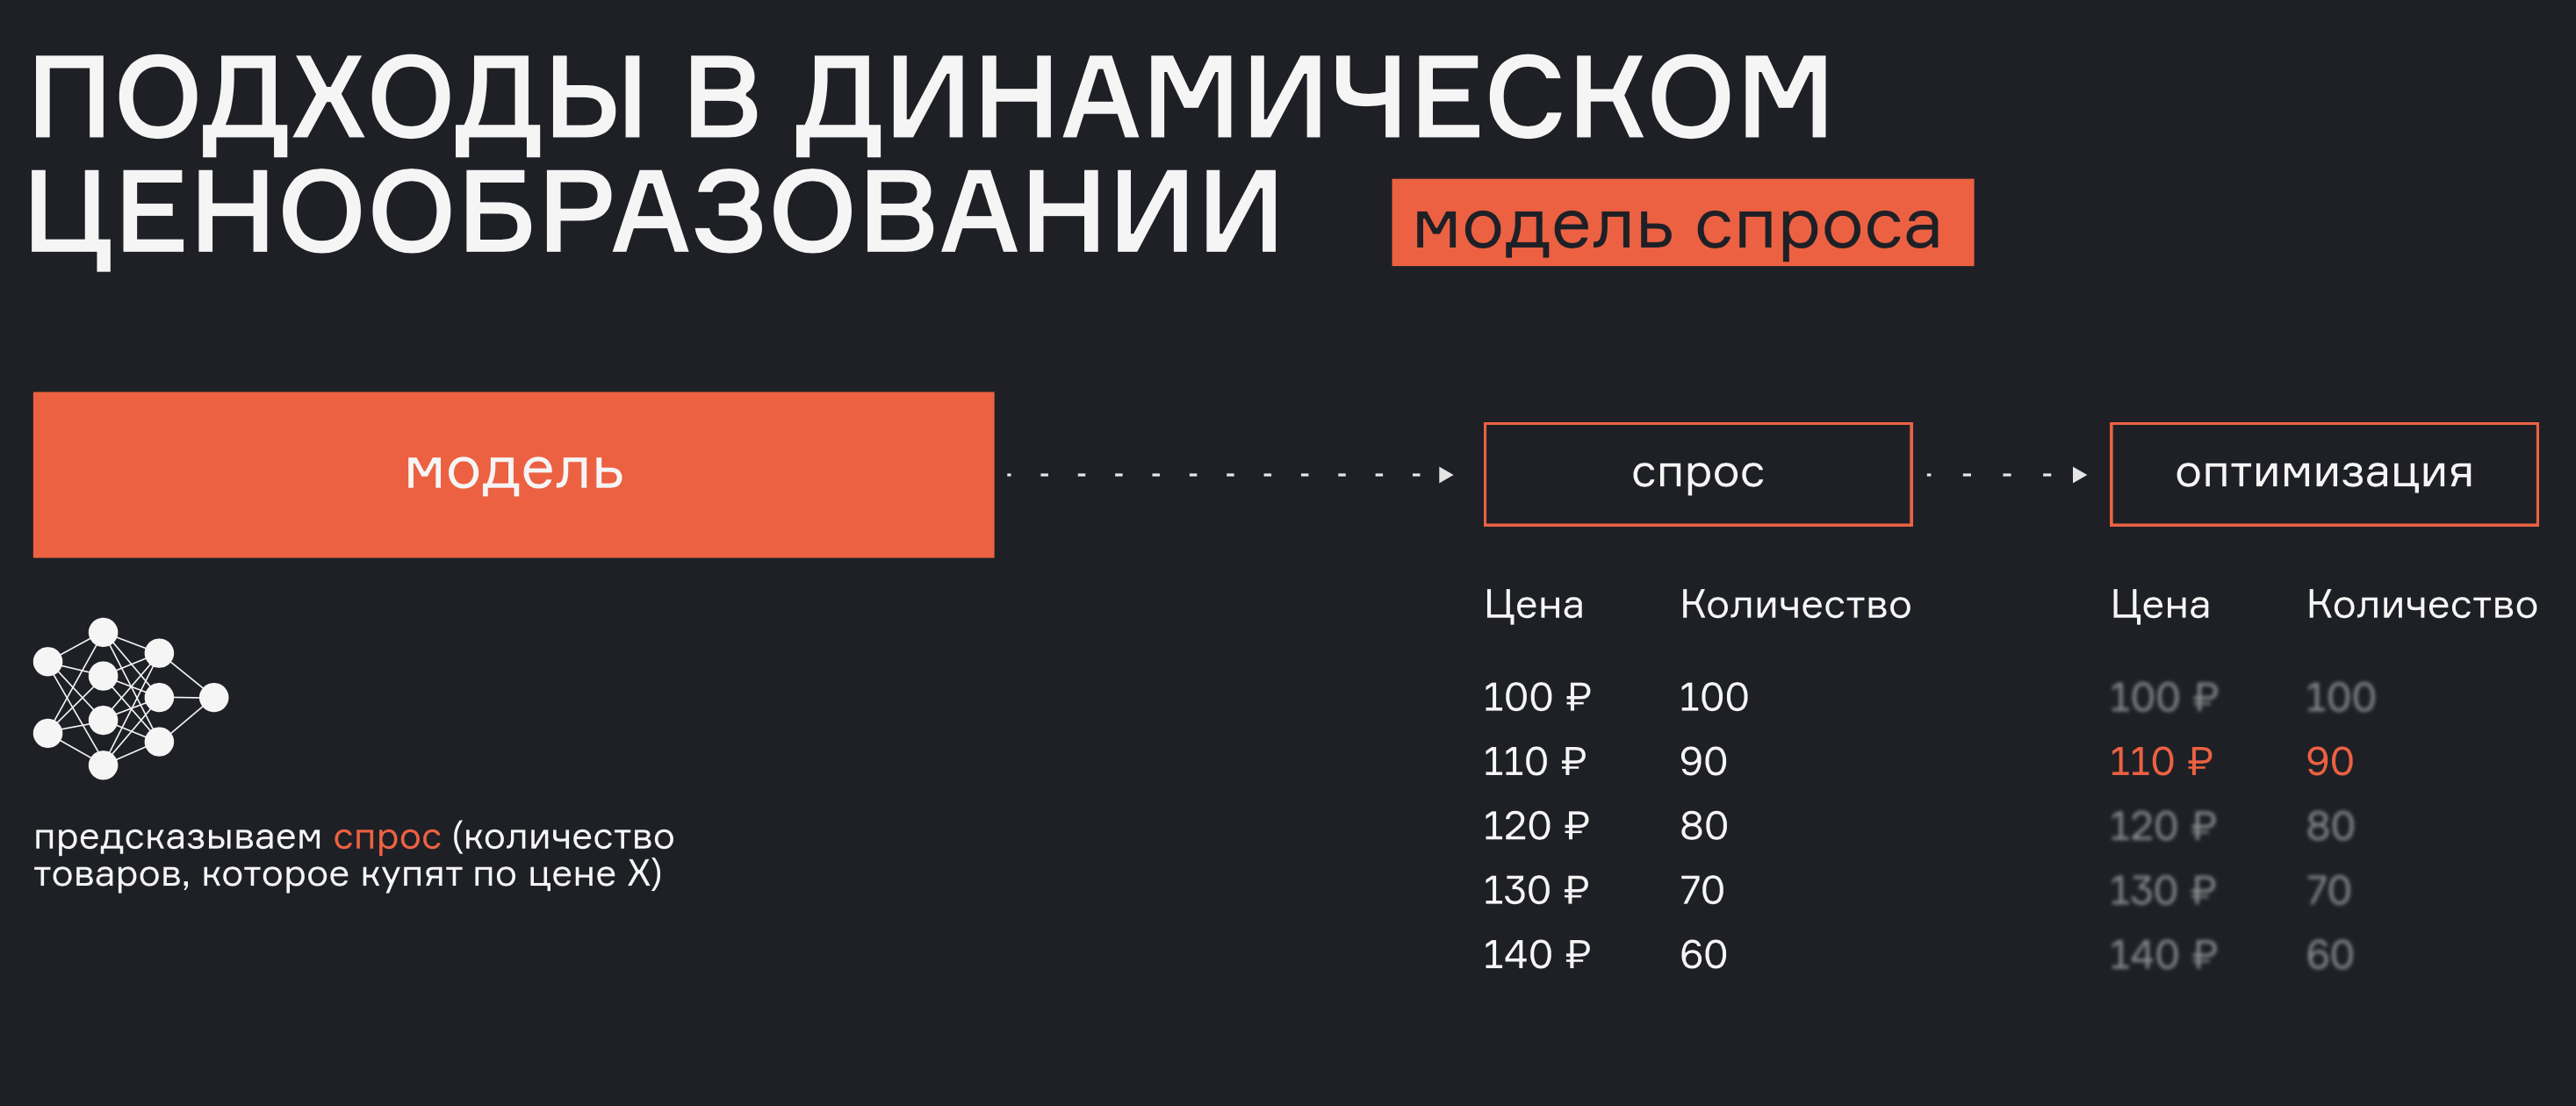

In [2]:
Image("./images/demand_approach.png", width=1000, height=400)

# Данные

Представим, что мы сделали 2 первых этапа в пайплайне (модели и спрос) и получили на выходе следующую таблицу:

<b>optimisation.csv</b> - таблица с предсказаниями модели из пайплайна динамического ценообразования

| Колонка        | Пояснение                                                                                |
|----------------|------------------------------------------------------------------------------------------|
| `item_id`      | ID товара                                                                                |
| `discount`     | скидка на товар                                                                          |
| `revenue`      | выручка по товару за эту дату                                                            |
| `orders_count` | количество заказов по товару за эту дату                                                 |
| `margin`       | прибыль по товару за эту дату                                                            |
| `ds`           | дата                                                                                     |

In [3]:
df = pd.read_csv("../data/optimisation.csv")
df.head()

,item_id,discount,revenue,orders_count,margin,ds
0,1,-0.10,969.0,10.0,14.0,20230101
1,1,-0.09,948.0,10.0,24.0,20230101
2,1,-0.08,928.0,9.0,33.0,20230101
3,1,-0.07,908.0,9.0,42.0,20230101
4,1,-0.06,890.0,8.0,50.0,20230101


# Ограничения

In [4]:
# Значения метрик в контрольной группе (в группе без маркапов и маркдаунов)
control_metrics = {
    metric: df[df["discount"] == 0][metric].sum()
    for metric in ["revenue", "margin", "orders_count"]
}
control_metrics

{'revenue': 427395.0, 'margin': 48279.0, 'orders_count': 6697.0}

# Вспомогательные функции

In [5]:
optimisation_result = {
    "algo": [],
    "revenue_uplift": [],
    "margin_uplift": [],
    "orders_count_uplift": []
}

In [6]:
from typing import Any, Dict


# Функция для подсчета аплифта на предсказаниях
def calculate_uplifts(
    control_metrics: Dict[str, float],
    optimal_df: pd.DataFrame,
    optimisation_result: Dict[str, Any],
    algo: str,
) -> None:
    for metric, control_value in control_metrics.items():
        test_value = optimal_df[metric].sum()
        uplift = round(test_value * 100 / control_value - 100)
        
        print(f"Control {metric}: {round(control_value)} руб.")
        print(f"Test margin: {round(test_value)} руб.")
        print(f"Uplift: {uplift} %")

        optimisation_result[f"{metric}_uplift"].append(uplift)
    optimisation_result["algo"].append(algo)

In [7]:
# Функция для построения графика распределения скидок
def plot_distribution(df: pd.DataFrame) -> None:
    plt.hist(df["discount"], bins=10, color="blue", edgecolor="black")
    plt.title('Распределение скидок')
    plt.xlabel('Размер скидки')
    plt.ylabel('Количество товаров')
    plt.show()

# Максимизация прибыли

In [8]:
# Нахождение индекса строки с максимальным margin для каждого sku_id по каждому дню
idx = df.groupby(["item_id", "ds"])["margin"].idxmax()
# Выбор соответствующих строк из исходного датасета
optimal_df = df.loc[idx]
optimal_df[["item_id", "discount", "discount", "ds"]].head()

,item_id,discount,discount,ds
20,1,0.10,0.10,20230101
41,2,0.10,0.10,20230101
60,3,0.08,0.08,20230101
82,4,0.09,0.09,20230101
88,5,-0.06,-0.06,20230101


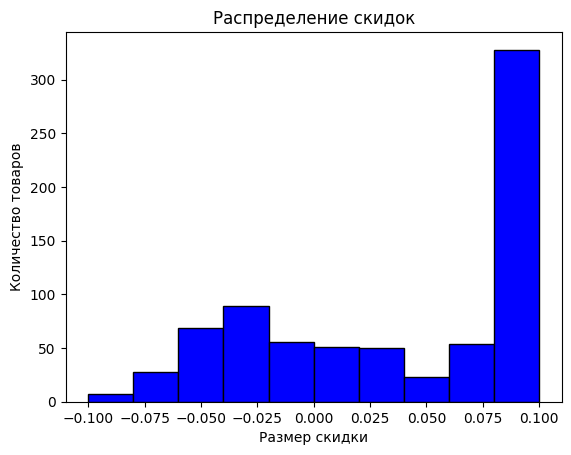

In [9]:
plot_distribution(df=optimal_df)

In [10]:
calculate_uplifts(
    control_metrics=control_metrics,
    optimal_df=optimal_df,
    optimisation_result=optimisation_result,
    algo="Максимизация прибыли",
)

Control revenue: 427395 руб.
Test margin: 407742 руб.
Uplift: -5 %
Control margin: 48279 руб.
Test margin: 66145 руб.
Uplift: 37 %
Control orders_count: 6697 руб.
Test margin: 6189 руб.
Uplift: -8 %


<font color="red">Как предполагалось, получили рост по прибыли, но при этом просадили 2 другие метрики - выручку и количество заказов. Давайте теперь не только растить прибыль, но и постараемся не просадить выручку.</font>

# Максимизация прибыли при непросадке выручки

In [11]:
import logging
from typing import List, Dict, Any

import numpy as np
import pandas as pd

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


def log_uplifts(
    constraints: Dict[str, float],
    maximized_column: str,
    optimal_statistics: Dict[str, float],
) -> None:
    """
    Функция для логирования значений метрик и их аплифтов (улучшений).

    :param constraints: Словарь ограничений для метрик.
    :param maximized_column: Название столбца, который подлежит максимизации.
    :param optimal_statistics: Словарь с оптимальными статистическими данными.
    """
    # Логируем значение метрики, которую мы максимизируем
    logger.info(f"Metric: {maximized_column}", extra={"value": optimal_statistics.get(maximized_column)})

    # Проходим по всем метрикам и их ограничениям
    for metric, constraint in constraints.items():
        optimal_value = optimal_statistics.get(metric)
        if optimal_value is None:
            raise ValueError(f"`{metric}` has not been counted")
        # Логируем информацию по каждой метрике, включая аплифты
        logger.info(
            f"Metric: {metric}",
            extra={
                "constraint value": round(constraint, 3),
                "optimal value": round(optimal_value, 3),
                "uplift (abs)": round(optimal_value - constraint, 3),
                "uplift (pct)": round(optimal_value * 100 / constraint - 100, 3),
            },
        )


def apply_constraints(
    df: pd.DataFrame,
    constraints: Dict[str, float],
) -> pd.DataFrame:
    """
    Фильтруем датасет по заданным ограничениям.

    :param df: DataFrame с данными для фильтрации.
    :param constraints: Словарь ограничений для каждой метрики.
    :return: Отфильтрованный DataFrame.
    """
    # Применяем ограничения к датафрейму, фильтруя строки
    for metric, constraint in constraints.items():
        df = df[df[metric] >= constraint]
    return df


def calculate_cum_lambda_metrics(
    df: pd.DataFrame,
    agg_columns: List[str],
    maximized_column: str,
) -> pd.DataFrame:
    """
    Считаем агрегированные значения метрик для каждой комбинации лямбда-значений.

    :param df: DataFrame с данными.
    :param agg_columns: Список столбцов для агрегации.
    :param maximized_column: Столбец, который максимизируется.
    :return: Агрегированный DataFrame.
    """
    # Группируем данные по комбинации лямбда-значений и агрегируем указанные столбцы
    df = df.groupby("lambda_combination").agg({column: "sum" for column in agg_columns})
    df = df.reset_index()
    return df


def choose_optimal_values(
    metric_lambda_map: Dict[str, float],
    df: pd.DataFrame,
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Находим оптимальные цены / наценки для каждого уровня для lambda_value
    """
    # Считаем лагранжианы при lambda_value
    df["lagrangian"] = df[maximized_column]
    lambda_combination_name = ""
    for metric, metric_lambda in metric_lambda_map.items():
        df["lagrangian"] += df[metric] * metric_lambda
        lambda_combination_name += f"{metric}={metric_lambda}_"
    # Находим максимальный лагранжиан для каждого уровня
    optimal_df = df.groupby(levels).agg({"lagrangian": "max"})
    df = df.merge(optimal_df, on=levels + ["lagrangian"], how="inner")
    # Добавляем колонку с lambda_value для запоминания
    df["lambda_combination"] = lambda_combination_name.strip("_")
    # Удаляем дубликаты (например, оставляем минимальные цены / наценки из оптимальных),
    # так как возможны одни и те же значения метрик для разных цен / наценок
    # => одинаковые лагранжианы, а нам нужно выбрать одно значение для каждого уровня
    df = df.sort_values(price_column)
    df = df.drop_duplicates(subset=levels)
    return df


def get_metric_lambda_maps(lambda_config: Dict[str, Any]) -> List[Dict[str, float]]:
    # Получаем список значений для каждого ключа
    lambda_lists = list(lambda_config.values())
    # Используем meshgrid для генерации всех комбинаций параметров
    lambda_mesh = np.meshgrid(*lambda_lists)
    # Преобразование в массив и решейпинг
    lambda_vars = np.stack(lambda_mesh, axis=-1).reshape(-1, len(lambda_config))
    # Создаем список словарей
    metric_lambda_maps = [
        dict(zip(lambda_config.keys(), combination)) for combination in lambda_vars
    ]
    return metric_lambda_maps


def calculate_lagrangians(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Для каждого значения lambda находим оптимальные цены / наценки для каждого уровня
    """
    lambda_dfs = []
    metric_lambda_maps = get_metric_lambda_maps(lambda_config=lambda_config)
    logger.info(
        f"Start calculating lagrangians, {len(metric_lambda_maps)} lambda combinations"
    )
    for metric_lambda_map in metric_lambda_maps:
        lambda_df = choose_optimal_values(
            metric_lambda_map=metric_lambda_map,
            df=df,
            levels=levels,
            price_column=price_column,
            maximized_column=maximized_column,
        )
        lambda_dfs.append(lambda_df)
    df = pd.concat(lambda_dfs)
    df = df.reset_index(drop=True)
    logger.info(f"Ended calculating lagrangians")
    return df


# Общая функция для оптимизации
def optimize(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    maximized_column: str,
    constraints: Dict[str, float],
    levels: List[str],
    price_column: str,
) -> pd.DataFrame:
    logger.info("Start choosing optimal prices")
    lambda_df = calculate_lagrangians(
        df=df,
        lambda_config=lambda_config,
        levels=levels,
        price_column=price_column,
        maximized_column=maximized_column,
    )
    statistics_df = calculate_cum_lambda_metrics(
        df=lambda_df,
        agg_columns=[maximized_column] + list(constraints.keys()),
        maximized_column=maximized_column,
    )
    statistics_df = statistics_df.sort_values(maximized_column, ascending=False)
    logger.info(f"\n{statistics_df.head()}")
    statistics_df = apply_constraints(df=statistics_df, constraints=constraints)
    logger.info(f"\n{statistics_df.head()}")
    best_lambda = statistics_df["lambda_combination"].tolist()[0]
    optimal_statistics = statistics_df[
        statistics_df["lambda_combination"] == best_lambda
    ].to_dict(orient="records")[0]
    optimal_df = lambda_df[lambda_df["lambda_combination"] == best_lambda]
    log_uplifts(
        constraints=constraints,
        maximized_column=maximized_column,
        optimal_statistics=optimal_statistics,
    )
    logger.info("Ended choosing optimal prices")
    return optimal_df

In [12]:
optimal_df = optimize(
    df=df,
    # перебираем разные lambda для выручки
    lambda_config={
        "revenue": np.arange(0.0, 1.0, 0.01).tolist(),
    },
    # указываем, что хотим максимизировать
    maximized_column="margin",
    # указываем ограничения
    constraints={
        "revenue": control_metrics["revenue"],
    },
    levels=["item_id"],
    price_column="discount",
)

INFO:__main__:Start choosing optimal prices
INFO:__main__:Start calculating lagrangians, 100 lambda combinations
INFO:__main__:Ended calculating lagrangians
INFO:__main__:
  lambda_combination   margin   revenue
0        revenue=0.0  66145.0  407742.0
1       revenue=0.01  66114.0  416780.0
2       revenue=0.02  65932.0  429912.0
3       revenue=0.03  65568.0  444895.0
4       revenue=0.04  64992.0  461718.0
INFO:__main__:
  lambda_combination   margin   revenue
2       revenue=0.02  65932.0  429912.0
3       revenue=0.03  65568.0  444895.0
4       revenue=0.04  64992.0  461718.0
5       revenue=0.05  64166.0  480073.0
6       revenue=0.06  63028.0  500486.0
INFO:__main__:Metric: margin
INFO:__main__:Metric: revenue
INFO:__main__:Ended choosing optimal prices


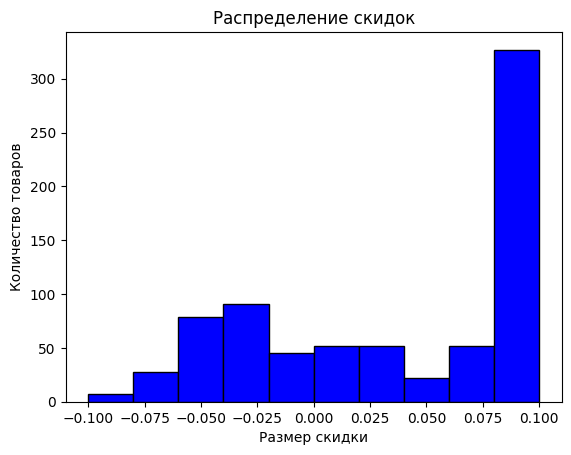

In [13]:
plot_distribution(df=optimal_df)

In [14]:
calculate_uplifts(
    control_metrics=control_metrics,
    optimal_df=optimal_df,
    optimisation_result=optimisation_result,
    algo="Максимизация прибыли при непросадке выручки",
)

Control revenue: 427395 руб.
Test margin: 429912 руб.
Uplift: 1 %
Control margin: 48279 руб.
Test margin: 65932 руб.
Uplift: 37 %
Control orders_count: 6697 руб.
Test margin: 6345 руб.
Uplift: -5 %


<font color="red">Как предполагалось, получили рост по прибыли и непросадку выручки относительно контрольной группы. Профит подхода в том, что он оптимизирует метрики для товаров в совокупности: мы можем просадить метрику у одного товара, но компенсировать это другим товаром. Это работает лучше, чем если бы мы работали в отдельности по каждому товару.</font>

<font color="red">Однако, в примере мы все еще просаживаем количество заказов. С помощью существующего кода давайте добавим еще ограничения на количество заказов.</font>

# Максимизация прибыли при непросадке выручки и количества заказов

In [15]:
optimal_df = optimize(
    df=df,
    # перебираем разные lambda для выручки и количества заказов
    lambda_config={
        "revenue": np.arange(0.0, 1.0, 0.01).tolist(),
        "orders_count": np.arange(0.0, 10.0, 1.0).tolist(),
    },
    # указываем, что хотим максимизировать
    maximized_column="margin",
    # указываем ограничения
    constraints={
        "revenue": control_metrics["revenue"],
        "orders_count": control_metrics["orders_count"],
    },
    levels=["item_id"],
    price_column="discount",
)

INFO:__main__:Start choosing optimal prices
INFO:__main__:Start calculating lagrangians, 1000 lambda combinations
INFO:__main__:Ended calculating lagrangians
INFO:__main__:
               lambda_combination   margin   revenue  orders_count
90   revenue=0.0_orders_count=0.0  66145.0  407742.0        6189.0
0   revenue=0.01_orders_count=0.0  66114.0  416780.0        6228.0
10  revenue=0.02_orders_count=0.0  65932.0  429912.0        6345.0
20  revenue=0.03_orders_count=0.0  65568.0  444895.0        6477.0
91   revenue=0.0_orders_count=1.0  65291.0  427771.0        7365.0
INFO:__main__:
               lambda_combination   margin   revenue  orders_count
91   revenue=0.0_orders_count=1.0  65291.0  427771.0        7365.0
1   revenue=0.01_orders_count=1.0  65162.0  436754.0        7435.0
11  revenue=0.02_orders_count=1.0  64866.0  447738.0        7570.0
92   revenue=0.0_orders_count=2.0  64280.0  443130.0        7972.0
21  revenue=0.03_orders_count=1.0  64233.0  465467.0        7774.0
INFO:__m

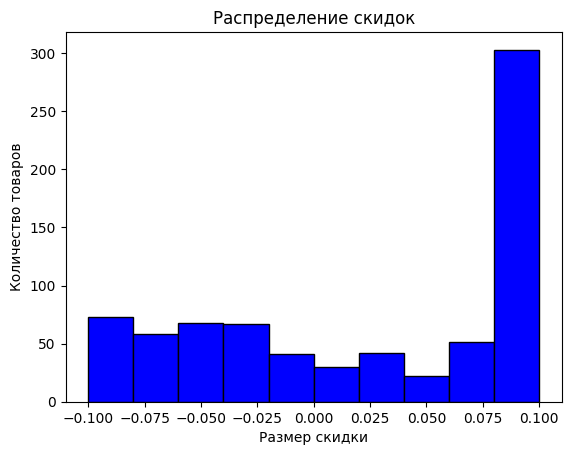

In [16]:
plot_distribution(df=optimal_df)

In [17]:
calculate_uplifts(
    control_metrics=control_metrics,
    optimal_df=optimal_df,
    optimisation_result=optimisation_result,
    algo="Максимизация прибыли при непросадке выручки и заказов",
)

Control revenue: 427395 руб.
Test margin: 427771 руб.
Uplift: 0 %
Control margin: 48279 руб.
Test margin: 65291 руб.
Uplift: 35 %
Control orders_count: 6697 руб.
Test margin: 7365 руб.
Uplift: 10 %


<font color="red">Ура! Получили то, что хотели: максимизировали прибыль при непросадке выручки и количества заказов. Если модель принятия решений основывается только на этих трех метриках - можно данную конфигурацию катить в онлайн тесты (предварительно измерив аплифты BackTest'ом). После онлайн теста стоит сравнить предсказываемые и реальные аплифты. Если они далеки друг о друга, следует больше поработать над моделью спроса - сделать ее более точной.</font>

# Результаты

In [18]:
pd.options.display.max_colwidth = 100
pd.DataFrame(optimisation_result)

,algo,revenue_uplift,margin_uplift,orders_count_uplift
0,Максимизация прибыли,-5,37,-8
1,Максимизация прибыли при непросадке выручки,1,37,-5
2,Максимизация прибыли при непросадке выручки и заказов,0,35,10


# Резюме

- имеем готовый инструмент для оптимизации различных метрик с ограничениями
- посмотрели, как работает оптимизация в 3-х случаях:
    - максимизация X
    - максимизация X при непросадке Y
    - максимизация X при непросадке Y и Z